Characterizations of data in iDigBio suitible for text mining

In [61]:
%matplotlib inline
from __future__ import print_function
import os
from pyspark import SQLContext
import pyspark.sql.functions as sql
#from pyspark.sql.functions import udf, length
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [2]:
# Load iDigBio Parquet
sqlContext = SQLContext(sc)
#idbdf = sqlContext.read.parquet("../data/idigbio/occurrence.txt.parquet")
idbdf = sqlContext.read.parquet("../data/idigbio-100k/occurrence.txt.parquet")
total_records = idbdf.count()
print(total_records)

99999


Let's start with the assumption that we know what fields are useful for looking for general features (we're not interested in parsing of taxonomic history or fields that are very specific to a single feature and require lots of domain knowlege to decode data representations.)

http://rs.tdwg.org/dwc/terms/dynamicProperties
http://rs.tdwg.org/dwc/terms/fieldNotes
http://portal.idigbio.org/terms/associateNotes
http://rs.tdwg.org/dwc/terms/occurrenceRemarks
http://rs.tdwg.org/dwc/terms/eventRemarks

Of these, dynamicProperties is best left for parsing. associateNotes is an iDigBio term that I'm not sure what it is. This leaves fieldNotes, occurrenceRemarks, and eventRemarks.

How many records have something in these fields?

In [36]:
# http://www.nodalpoint.com/unexpected-behavior-of-spark-dataframe-filter-method/
# Use SQL syntax here because column names suck, alias columns to make life easier
idbdf.registerTempTable("idbtable")
notes = sqlContext.sql("""
                       SELECT
                        `http://portal.idigbio.org/terms/uuid` as uuid,
                        `http://rs.tdwg.org/dwc/terms/occurrenceID` as occurrenceID,
                        `http://rs.tdwg.org/dwc/terms/catalogNumber` as catalogNumber,
                        `http://rs.tdwg.org/dwc/terms/county` as county,
                        `http://rs.tdwg.org/dwc/terms/institutionCode` as institutionCode,
                        `http://rs.tdwg.org/dwc/terms/country` as country,
                        `http://rs.tdwg.org/dwc/terms/countryCode` as countryCode,
                        `http://rs.tdwg.org/dwc/terms/stateProvince` as stateProvince,
                        `http://rs.tdwg.org/dwc/terms/family` as family,
                        `http://rs.tdwg.org/dwc/terms/recordedBy` as recordedBy,
                        `http://rs.tdwg.org/dwc/terms/order` as `order`,
                        `http://rs.tdwg.org/dwc/terms/specificEpithet` as specificEpithet,
                        `http://rs.tdwg.org/dwc/terms/genus` as genus,
                        `http://rs.tdwg.org/dwc/terms/sex` as sex,
                        `http://rs.tdwg.org/dwc/terms/scientificName` as scientificName,
                        `http://rs.tdwg.org/dwc/terms/year` as year,
                        `http://rs.tdwg.org/dwc/terms/month` as month,
                        `http://rs.tdwg.org/dwc/terms/fieldNotes` as fieldNotes,
                        `http://rs.tdwg.org/dwc/terms/occurrenceRemarks` as occurrenceRemarks,
                        `http://rs.tdwg.org/dwc/terms/eventRemarks` as eventRemarks
                       FROM idbtable WHERE 
                       `http://rs.tdwg.org/dwc/terms/fieldNotes` != '' OR
                       `http://rs.tdwg.org/dwc/terms/occurrenceRemarks` != '' OR 
                       `http://rs.tdwg.org/dwc/terms/eventRemarks` != ''
                       """)
notes_records = notes.count()
print(notes_records)
print(1.0 * notes_records/total_records * 100)

20745
20.7452074521


Lets do some string length calcuations and make some new columns in Spark before switching to Pandas

In [62]:
# Add a column that is the concatenation of all the fields
#def combine(f, o, e):
#    return f + " " + o + " " + e
#combine_udf = udf(combine)
#notes = notes.withColumn('document', combine_udf(notes['fieldNotes'], 
#                                                     notes['occurrenceRemarks'],
#                                                     notes['eventRemarks']))

# This results in None's in the concatenated strings.
#notes = notes.select(sql.concat_ws(' ', notes['fieldNotes'],
#                               notes['occurrenceRemarks'],
#                              notes['eventRemarks']).alias('document'))


# Add columns that are the lengths
notes = notes.withColumn('document_len', sql.length(notes['document']))

In [63]:
for r in notes.head(10):
    print(r['document'])

Py4JJavaError: An error occurred while calling z:org.apache.spark.sql.execution.EvaluatePython.takeAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 45.0 failed 1 times, most recent failure: Lost task 0.0 in stage 45.0 (TID 84, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/spark/python/pyspark/sql/functions.py", line 1563, in <lambda>
    func = lambda _, it: map(lambda x: returnType.toInternal(f(*x)), it)
  File "<ipython-input-49-63a0bb37083a>", line 2, in combine
TypeError: coercing to Unicode: need string or buffer, NoneType found

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:129)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:125)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$$anon$13.hasNext(Iterator.scala:371)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:913)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:929)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:969)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:972)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1157)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1765)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1832)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1845)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1858)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:212)
	at org.apache.spark.sql.execution.EvaluatePython$$anonfun$takeAndServe$1.apply$mcI$sp(python.scala:126)
	at org.apache.spark.sql.execution.EvaluatePython$$anonfun$takeAndServe$1.apply(python.scala:124)
	at org.apache.spark.sql.execution.EvaluatePython$$anonfun$takeAndServe$1.apply(python.scala:124)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:56)
	at org.apache.spark.sql.DataFrame.withNewExecutionId(DataFrame.scala:2086)
	at org.apache.spark.sql.execution.EvaluatePython$.takeAndServe(python.scala:124)
	at org.apache.spark.sql.execution.EvaluatePython.takeAndServe(python.scala)
	at sun.reflect.GeneratedMethodAccessor95.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/spark/python/pyspark/sql/functions.py", line 1563, in <lambda>
    func = lambda _, it: map(lambda x: returnType.toInternal(f(*x)), it)
  File "<ipython-input-49-63a0bb37083a>", line 2, in combine
TypeError: coercing to Unicode: need string or buffer, NoneType found

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:129)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:125)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$$anon$13.hasNext(Iterator.scala:371)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:913)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:929)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:969)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:972)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:327)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1157)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:452)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:280)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1765)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:239)


What are typical lengths of text to work with here? Histogram of length of the document texts

In [13]:
# make a Pandas data frame to work with, this is expensive-ish depending on data size, 
# perhaps we should cut back on the columns in the select statement and alias them to make
# life better? -- OOM's with full data set
notes_pd = notes.toPandas()

<class 'pandas.core.frame.DataFrame'>


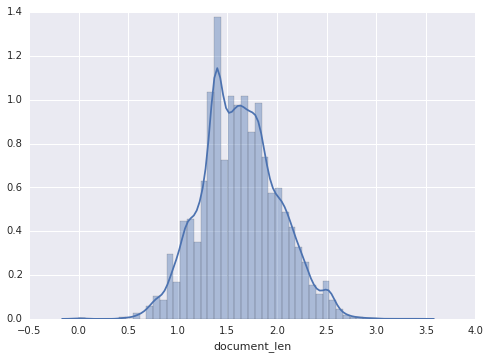

In [14]:
print(type(notes_pd))

# I guess there are some None's in the column...
def wow(r):
    if r['document'] is None:
        return 0
    else:
        return math.log10(len(r['document']))
    
notes_pd['document_len'] = notes_pd.apply(lambda r: wow(r), axis=1) 
#print(notes_pd.head())
sns.distplot(notes_pd['document_len'])

In [15]:
# Really, I have ones that are 10k characters? - no, base e vs base 10,
# have ~10 - 150 characters
first_row = notes_pd.loc[notes_pd['document_len'] > 1.5].head(1)
# Why can't I just print the contents?
print(first_row['document_len'])
print('"')
for c in first_row['document']:
    print(c)
print('"')

0    1.838849
Name: document_len, dtype: float64
"
 SVL 43.0 mm, Total 112.0 mm, WT 1.1 gm.  Time constrained searches. 
"
